### Multi-classification using AlexNet

#### 1. Problem Statement

The goal of this project is to build a multi-classifier using AlexNet model for vegetable classification.

#### 2. Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import itertools

%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-iipajxdm
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-iipajxdm
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4991 sha256=cc89830ca67372e127906b2ca3b39f1e9b857fee773c710ed35589bd40588e11
  Stored in directory: /tmp/pip-ephem-wheel-cache-4p67xspq/wheels/69/06/fd/652908d49c931cdcca96be3c727fb11ed777a3a62402210396
Successfully built torchviz


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import *

#### 3. Define Hyperparameters

In [ ]:
num_classes = 15

batch_size = 128

num_epochs = 101

learning_rate = 1e-2

weight_decay = 5e-4

device = 'cuda'

root = '/'

img_size = 224

#### 4. Define Dataset Class

PyTorch Dataset class builds the data in a tuple and gives us access to each index.

In [ ]:
data_augmentation_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop((img_size, img_size)),
    transforms.RandomErasing(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4)
])

data_augmentation_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size))
])

In [ ]:
def get_img_path_label_list(root, mode):
    img_path_list = []
    img_label_list = []
    sub_folders = next(os.walk(os.path.join(root, mode)))[1]
    for i in sub_folders:
        sub_img_path = list(glob.glob(os.path.join(root, mode, i, '*.jpg')))
        count = 0
        for j in sub_img_path:
            if mode == 'train':
                if count < 150:
                    img_path_list.append(j)
                    img_label_list.append(i)
                    count += 1
            else:
                if count < 50:
                    img_path_list.append(j)
                    img_label_list.append(i)
                    count += 1
    
    img_label_one_hot_list = {}
    for i in range(len(sub_folders)):
        img_label_one_hot_list[sub_folders[i]] = i

    return img_path_list, img_label_list, img_label_one_hot_list

In [ ]:
class Vegetable(Dataset):
    def __init__(self, root, mode, aug):
        assert mode in ['train', 'validation', 'test']

        self.root = root
        self.mode = mode
        self.aug = aug

        self.img_path, self.img_label, self.img_label_one_hot = get_img_path_label_list(root, mode)

    def __getitem__(self, index):
        img = Image.open(self.img_path[index])

        img = self.aug(img)
        img = img.float()

        label = self.img_label[index]

        label_one_hot = self.img_label_one_hot[label]
        
        return img, label, label_one_hot

    def __len__(self):
        length = len(self.img_path)
        
        return length

#### 5. Build Dataset

In [ ]:
def get_dataset(root, mode, aug):
    assert mode in ['train', 'validation', 'test']
    return Vegetable(root, mode, aug)

#### 6. Build Dataloader

In [ ]:
def get_dataloader(root, mode, batch_size, aug):
    assert mode in ['train', 'validation', 'test']
    
    shuffle = True
    num_workers = 2
    
    dataset = get_dataset(root, mode, aug)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return dataloader

#### 7. Load Data Sets

In [ ]:
train_loader = get_dataloader(root, 'train', batch_size, data_augmentation_train)
val_loader = get_dataloader(root, 'validation', batch_size, data_augmentation_test)
test_loader = get_dataloader(root, 'test', batch_size, data_augmentation_test)

#### 8. Visualize Training Data

The shape of a batch of images: torch.Size([128, 3, 224, 224])


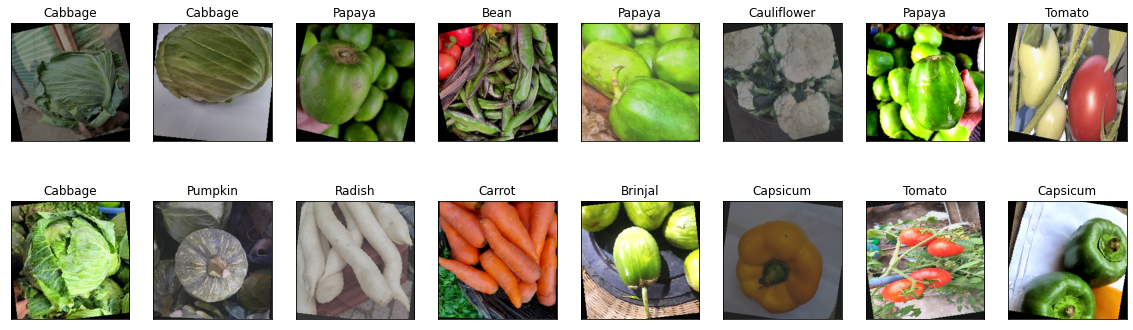

In [ ]:
for images, labels, labels_one_hot in train_loader:
    print(f'The shape of a batch of images: {images.shape}')

    labels_print = labels[: 16]
    images_print = torch.permute(images[: 16], (0, 2, 3, 1)).detach().numpy()
    
    _, axs = plt.subplots(2, 8, figsize=(20, 6))
    axs = axs.flatten()

    i = 0
    for img, ax in zip(images_print, axs):
        ax.set_title(labels[i])

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(img)
        i += 1
    plt.show()
    break

#### 9. Build DNN Model

Define the layers, neurons, and activation function.

##### 9.1 Model Structure
- Input layer: 1

- Hidden layers: 1 or 2

- Add batch normalization layer between each layer.

- Add dropout layer before the output layer.

- Add Sigmoid function at the output layer to make probabilities between 0 to 1.

- Activation function: ReLU (between hidden layers)

In [ ]:
class VegetableMultiClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

        self.net = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Flatten(),

            # Replaced by following block
            nn.Linear(6400, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, self.num_classes),
        )

        def _init_weights(m):
          if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

        self.net.apply(_init_weights)

    def forward(self, x):
        x = self.net(x)
        return x

#### 10. Visualize Model

In [ ]:
model_basic = VegetableMultiClassifier(num_classes)
print(model_basic)

VegetableMultiClassifier(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), strid

In [ ]:
from torchsummary import summary
summary(model_basic.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
       BatchNorm2d-2           [-1, 96, 54, 54]             192
              ReLU-3           [-1, 96, 54, 54]               0
         MaxPool2d-4           [-1, 96, 26, 26]               0
            Conv2d-5          [-1, 256, 26, 26]         614,656
       BatchNorm2d-6          [-1, 256, 26, 26]             512
              ReLU-7          [-1, 256, 26, 26]               0
         MaxPool2d-8          [-1, 256, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]         885,120
      BatchNorm2d-10          [-1, 384, 12, 12]             768
             ReLU-11          [-1, 384, 12, 12]               0
           Conv2d-12          [-1, 384, 12, 12]       1,327,488
      BatchNorm2d-13          [-1, 384, 12, 12]             768
             ReLU-14          [-1, 384,

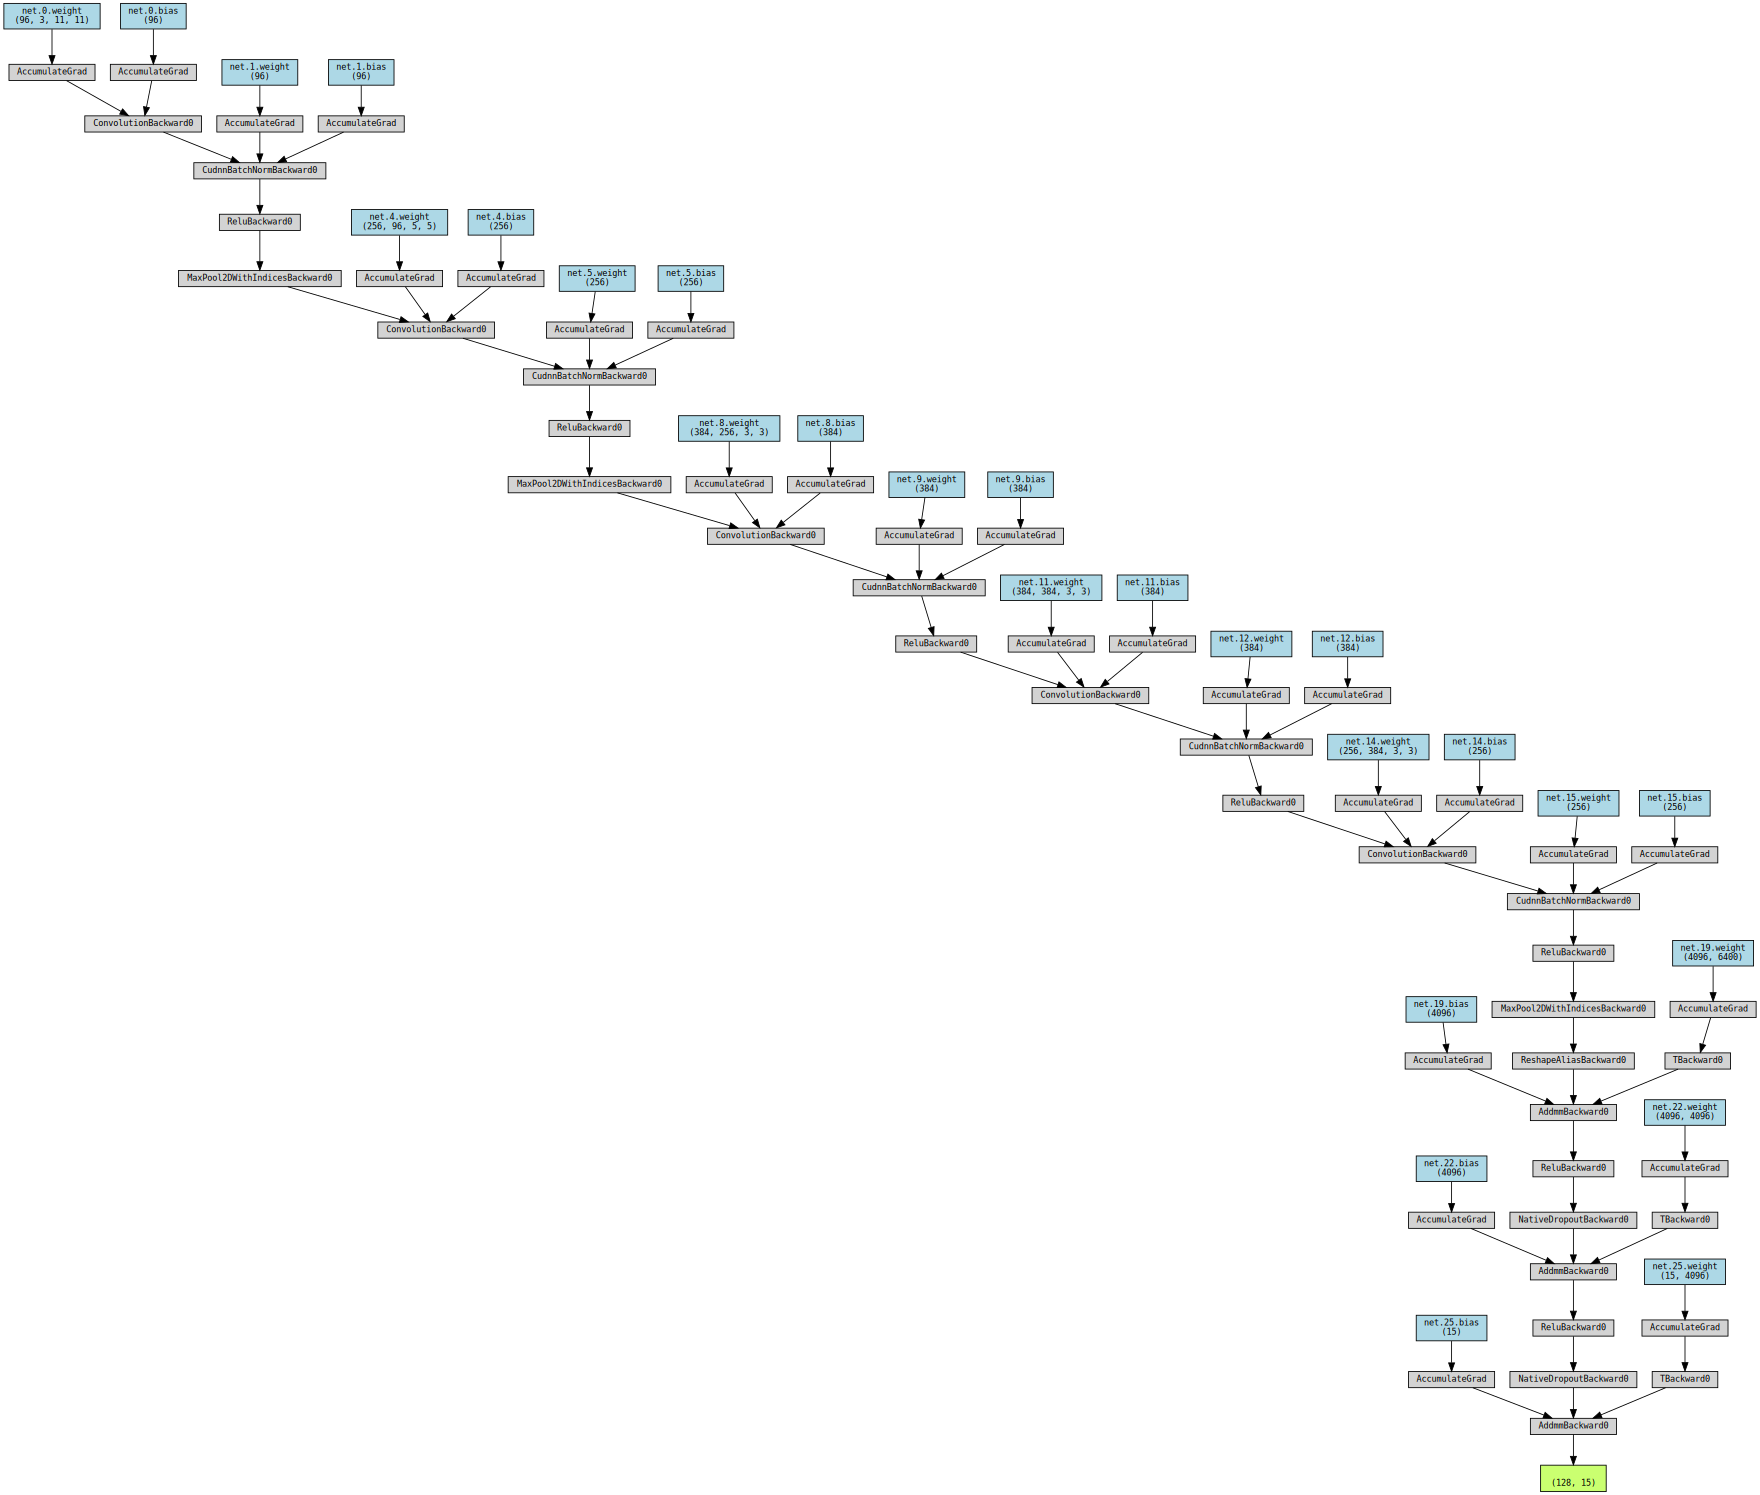

In [ ]:
t = torch.randn(batch_size, 3, 224, 224)
make_dot(model_basic(t.to(device)), params=dict(model_basic.named_parameters()))

#### 11. Training Process

- Criterion (loss function): Cross Entropy Loss (CE) commonly used for multi-classification tasks.

- Optimizer: SGD optimizer

We turn the model into training mode using 'model.train()' during training process and switch the model into evaluation mode using 'model.eval()' during validation process.

This is because layers, such as Dropout and BatchNorm behave differently during different processes. We need to specify what actions we want PyTorch to take.

In [ ]:
def train(num_classes,
          device,
          num_epochs,
          train_loader,
          learning_rate,
          weight_decay):

    model = VegetableMultiClassifier(num_classes).to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    lr_list = []

    # Train the model
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_label = 0

        model.train()
        for features, labels, labels_one_hot in train_loader:
            features, labels_one_hot = features.to(device), labels_one_hot.to(device)
            
            pred = model(features)

            pred_label = torch.max(pred, 1)[1]

            loss = criterion(pred, labels_one_hot)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (pred_label == labels_one_hot).sum().item()
            total_label += labels_one_hot.size(0)

        scheduler.step()
        lr_list.append(scheduler._last_lr)

        train_loss_list.append(total_loss / len(train_loader))
        train_acc_list.append(total_correct / total_label)

        if epoch % 10 == 0:
            total_val_loss = 0
            total_val_correct = 0
            total_val_label = 0

            model.eval()
            for features_val, labels_val, labels_one_hot_val in val_loader:
                features_val, labels_one_hot_val = features_val.to(device), labels_one_hot_val.to(device)
                
                pred_val = model(features_val)

                pred_val_label = torch.max(pred_val, 1)[1]

                loss_val = criterion(pred_val, labels_one_hot_val)                

                total_val_loss += loss_val.item()
                total_val_correct += (pred_val_label == labels_one_hot_val).sum().item()
                total_val_label += labels_one_hot_val.size(0)

            val_loss_list.append(total_val_loss / len(val_loader))
            val_acc_list.append(total_val_correct / total_val_label)

            print(f'Epoch {epoch+0:03}: | Loss: {total_loss/len(train_loader):.5f} | Train Acc: {total_correct/total_label:.5f} | Val Acc: {total_val_correct/total_val_label:.5f}')
      
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list, lr_list, model

In [ ]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list, lr_list, model = train(num_classes,
                                                                                     device,
                                                                                     num_epochs,
                                                                                     train_loader,
                                                                                     learning_rate,
                                                                                     weight_decay)

Epoch 000: | Loss: 3.52115 | Train Acc: 0.14222 | Val Acc: 0.06800
Epoch 010: | Loss: 1.17247 | Train Acc: 0.60356 | Val Acc: 0.40667
Epoch 020: | Loss: 0.72711 | Train Acc: 0.74800 | Val Acc: 0.62533
Epoch 030: | Loss: 0.48967 | Train Acc: 0.82978 | Val Acc: 0.58667
Epoch 040: | Loss: 0.34126 | Train Acc: 0.88533 | Val Acc: 0.91733
Epoch 050: | Loss: 0.22415 | Train Acc: 0.93111 | Val Acc: 0.92800
Epoch 060: | Loss: 0.20577 | Train Acc: 0.93778 | Val Acc: 0.92533
Epoch 070: | Loss: 0.19594 | Train Acc: 0.94089 | Val Acc: 0.93867
Epoch 080: | Loss: 0.17442 | Train Acc: 0.94889 | Val Acc: 0.94000
Epoch 090: | Loss: 0.16565 | Train Acc: 0.95200 | Val Acc: 0.94000
Epoch 100: | Loss: 0.17481 | Train Acc: 0.94667 | Val Acc: 0.94133


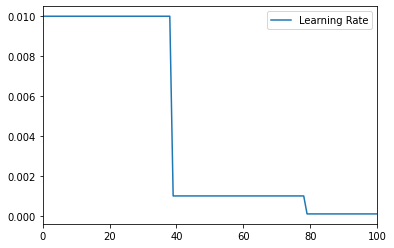

In [ ]:
plt.plot(np.linspace(0, num_epochs - 1, len(lr_list)), lr_list, label='Learning Rate')
plt.xlim((0, num_epochs - 1))
plt.legend()
plt.show()

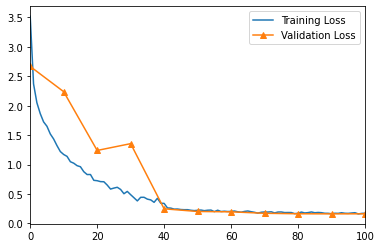

In [ ]:
plt.plot(np.linspace(0, num_epochs - 1, len(train_loss_list)), train_loss_list, label='Training Loss')
plt.plot(np.linspace(0, num_epochs - 1, len(val_loss_list)), val_loss_list, marker='^', label='Validation Loss')
plt.xlim((0, num_epochs - 1))
plt.legend()
plt.show()

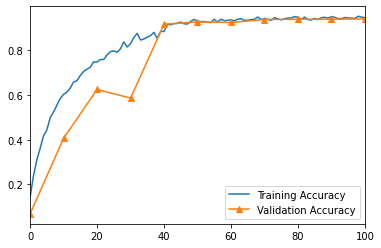

In [ ]:
plt.plot(np.linspace(0, num_epochs - 1, len(train_acc_list)), train_acc_list, label = 'Training Accuracy')
plt.plot(np.linspace(0, num_epochs - 1, len(val_acc_list)), val_acc_list, marker='^', label = 'Validation Accuracy')
plt.xlim((0, num_epochs - 1))
plt.legend()
plt.show()

#### 12. Testing Process

We switch the model into evaluation mode, and use 'torch.no_grad()' to stop the back propagation process during testing process. This is because we do not want to change the learned parameters in the neural network to test their performance.

In [ ]:
def test(model, test_loader, device):
    label_test_list = []
    pred_test_list = []
    
    model.eval()
    with torch.no_grad():
        for features, labels, labels_one_hot in test_loader:
            features, labels_one_hot = features.to(device), labels_one_hot.to(device)

            pred_test = model(features)

            pred_test_list.append(torch.max(pred_test, 1)[1].cpu().numpy())
            label_test_list.append(labels_one_hot.cpu().numpy())

    return label_test_list, pred_test_list

#### 13. Experiment & Evaluation

##### 13.1 Evaluation Metric

- Accuracy

- Confusion Matrix

- Precision

- Recall

- F1 Score

In [ ]:
label_test_list, pred_test_list = test(model, test_loader, device)

In [ ]:
total_correct_test = 0
total_label_test = 0
for i in range(len(label_test_list)):
    total_correct_test += (label_test_list[i] == pred_test_list[i]).sum()
    total_label_test += len(label_test_list[i])

print(f'Test Accuracy: {total_correct_test/total_label_test:.3f}')

Test Accuracy: 0.952


In [ ]:
label_test_list = [a.squeeze().tolist() for a in label_test_list]
label_test_list = list(itertools.chain.from_iterable(label_test_list))

pred_test_list = [a.squeeze().tolist() for a in pred_test_list]
pred_test_list = list(itertools.chain.from_iterable(pred_test_list))

In [ ]:
conf_mat = confusion_matrix(label_test_list, pred_test_list)
print('Confusion Matrix of the Test Set: ')
print(conf_mat)

precision = precision_score(label_test_list, pred_test_list, average='macro')
print(f'Precision of the MLP: {precision:.3f}')

recall = recall_score(label_test_list, pred_test_list, average='micro')
print(f'Recall of the MLP: {recall:.3f}')

f1_score = f1_score(label_test_list, pred_test_list, average='micro')
print(f'F1 Score of the MLP: {f1_score:.3f}')

Confusion Matrix of the Test Set: 
[[50  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 48  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 47  1  2  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  1 43  2  1  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0 48  1  0  0  1  0  0  0]
 [ 0  0  0  2  0  0  0  0 46  0  1  0  0  1  0]
 [ 0  0  1  0  0  1  0  1  0 46  1  0  0  0  0]
 [ 1  0  0  0  0  3  0  0  4  0 42  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0 47  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 50  0  0]
 [ 1  0  1  0  0  0  0  0  0  0  0  0  1 47  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 50]]
Precision of the MLP: 0.952
Recall of the MLP: 0.952
F1 Score of the MLP: 0.952


##### 13.2 Confusion Matrix

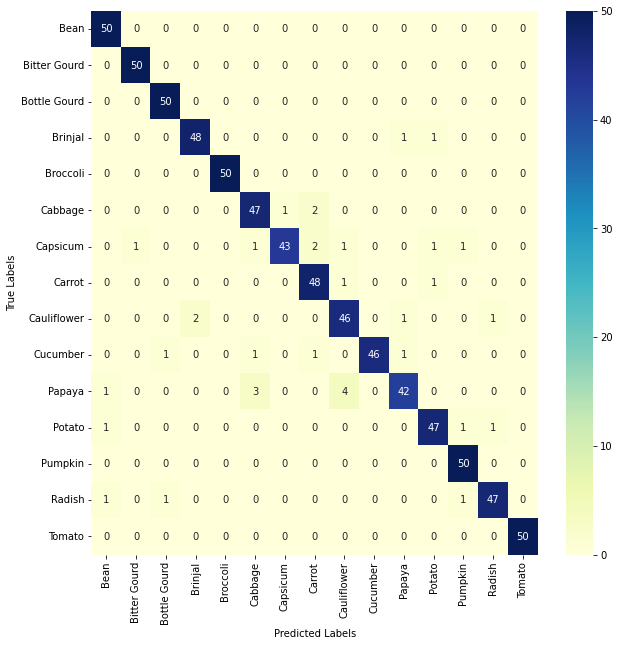

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

label_list = ['Bean', 'Bitter Gourd', 'Bottle Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

plt.figure(figsize=(10,10))
cm = confusion_matrix(label_test_list, pred_test_list)
ax = sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
ax.set_ylabel('True Labels')
ax.set_xlabel('Predicted Labels')
plt.show()

##### 13.3 ROC-AUC Curve for multi-classification

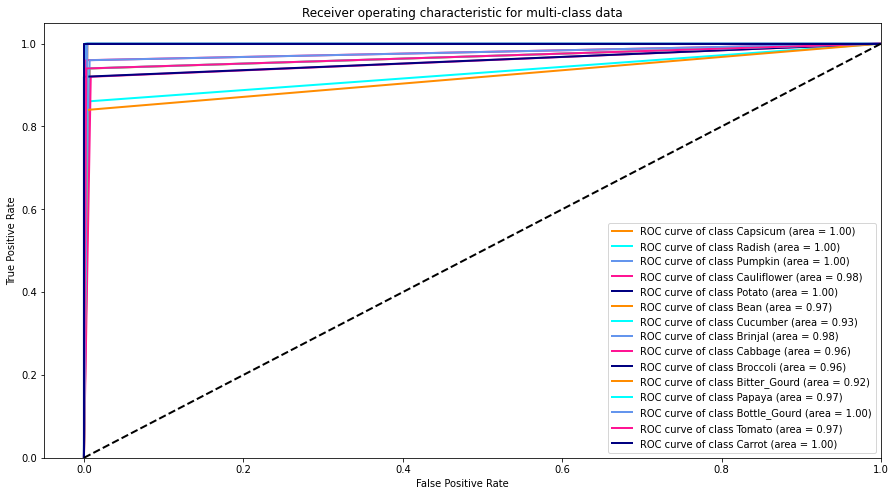

In [ ]:
from itertools import cycle

label_test_list_one_hot = F.one_hot(torch.tensor(np.array(label_test_list)), num_classes = num_classes)
pred_test_list_one_hot = F.one_hot(torch.tensor(np.array(pred_test_list)), num_classes = num_classes)

_, _, img_label_one_hot_list = get_img_path_label_list(root, 'test')

fpr = dict()
tpr = dict()
roc_auc = dict()

lw=2
plt.figure(figsize=(15, 8))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test_list_one_hot[:, i], pred_test_list_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['darkorange', 'aqua', 'cornflowerblue', 'deeppink', 'navy'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(list(img_label_one_hot_list.keys())[list(img_label_one_hot_list.values()).index(i)], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

##### 13.4 Prediction Reuslts

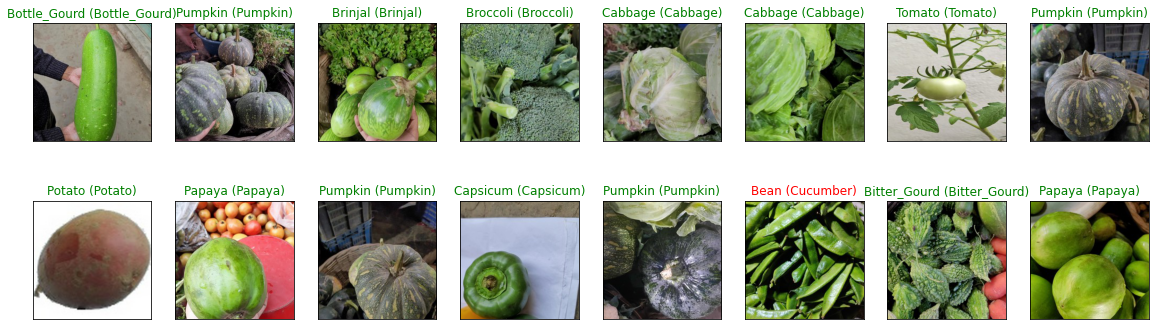

In [ ]:
model.eval()
with torch.no_grad():

    for features, labels, labels_one_hot in test_loader:
        features, labels_one_hot = features.to(device), labels_one_hot.to(device)

        pred_test = model(features)

        pred_print = torch.max(pred_test, 1)[1].cpu().numpy()[: 16]
        labels_one_hot = labels_one_hot[: 16].cpu().numpy()
        feature_print = torch.permute(features[: 16], (0, 2, 3, 1)).detach().cpu().numpy()

        _, _, img_label_one_hot_list = get_img_path_label_list(root, 'test')

        _, axs = plt.subplots(2, 8, figsize=(20, 6))
        axs = axs.flatten()
        i = 0
        for img, ax in zip(feature_print, axs):
            if labels_one_hot[i] == pred_print[i]:
                title_color = 'green'
            else:
                title_color = 'red'
            first_word = labels[i]
            second_word = list(img_label_one_hot_list.keys())[list(img_label_one_hot_list.values()).index(int(pred_print[i]))]

            ax.set_title(first_word + ' (' + second_word + ')', color=title_color)

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.imshow(img)
            i += 1
        plt.show()
        break

We plot the first 16 images of a batch of images in the test dataset. The first word in each title is the truth label. The word in the parentheses represents the predicted label of our model. The images with green titles indicate the correct prediction. The red titles represent the wrong predictions. For example, the second image in the first row is a shirt. We mispredicted it as a pullover.

#### 14. Save the Trained Model

In [ ]:
torch.save(model, '/AlexNet.pth')